In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Configure visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
# --- 1. DATA LOADING AND INITIAL INSPECTION ---
print("--- 1. DATA LOADING ---")

try:
    # Use chunking/sampling to prevent memory exhaustion on large datasets.
    # We load the first 100,000 rows as a safe starting point. 
    # If this runs successfully, you can try removing 'nrows' to load the full file.
    df = pd.read_csv("crop_yield.csv", nrows=100000, 
                    dtype={
                        'Rainfall_mm': np.float32, 
                        'Temperature_Celsius': np.float32,
                        'Days_to_Harvest': np.int16,
                        'Yield_tons_per_hectare': np.float32
                    })
    
    # Ensure boolean columns are correctly inferred or coerced if they aren't 'True'/'False' strings
    df['Fertilizer_Used'] = df['Fertilizer_Used'].astype(str).str.lower().map({'true': 1, 'false': 0}).fillna(0).astype(int)
    df['Irrigation_Used'] = df['Irrigation_Used'].astype(str).str.lower().map({'true': 1, 'false': 0}).fillna(0).astype(int)

    print(f"Successfully loaded dataset (first {len(df)} rows). Shape: {df.shape}")

except FileNotFoundError:
    print("Error: 'crop_yield.csv' not found. Please ensure the file is uploaded or in the correct path.")
    exit()
except Exception as e:
    print(f"An unexpected error occurred during file loading: {e}")
    exit()


# Display initial data information
print("\nInitial DataFrame Info:")
df.info()
print("\nFirst 5 rows:")
print(df.head())
print("-" * 60)


--- 1. DATA LOADING ---
Successfully loaded dataset (first 100000 rows). Shape: (100000, 10)

Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Region                  100000 non-null  object 
 1   Soil_Type               100000 non-null  object 
 2   Crop                    100000 non-null  object 
 3   Rainfall_mm             100000 non-null  float32
 4   Temperature_Celsius     100000 non-null  float32
 5   Fertilizer_Used         100000 non-null  int64  
 6   Irrigation_Used         100000 non-null  int64  
 7   Weather_Condition       100000 non-null  object 
 8   Days_to_Harvest         100000 non-null  int16  
 9   Yield_tons_per_hectare  100000 non-null  float32
dtypes: float32(3), int16(1), int64(2), object(4)
memory usage: 5.9+ MB

First 5 rows:
  Region Soil_Type     Crop  Rainfall

In [4]:
# --- 2. DATA PREPROCESSING AND CLEANING ---
print("--- 2. DATA PREPROCESSING ---")

# A. Handle Missing Values (Check for Nulls)
print(f"Total missing values before treatment: {df.isnull().sum().sum()}")
# Drop any rows where the target variable is missing (critical for training)
df.dropna(subset=['Yield_tons_per_hectare'], inplace=True)


# B. Define features for One-Hot Encoding
nominal_features = ['Region', 'Soil_Type', 'Crop', 'Weather_Condition']
df_encoded = pd.get_dummies(df, columns=nominal_features, drop_first=True)

print("Preprocessing complete. New shape after encoding:", df_encoded.shape)
print(f"New column names (features): {list(df_encoded.columns)}")
print("-" * 60)


--- 2. DATA PREPROCESSING ---
Total missing values before treatment: 0
Preprocessing complete. New shape after encoding: (100000, 21)
New column names (features): ['Rainfall_mm', 'Temperature_Celsius', 'Fertilizer_Used', 'Irrigation_Used', 'Days_to_Harvest', 'Yield_tons_per_hectare', 'Region_North', 'Region_South', 'Region_West', 'Soil_Type_Clay', 'Soil_Type_Loam', 'Soil_Type_Peaty', 'Soil_Type_Sandy', 'Soil_Type_Silt', 'Crop_Cotton', 'Crop_Maize', 'Crop_Rice', 'Crop_Soybean', 'Crop_Wheat', 'Weather_Condition_Rainy', 'Weather_Condition_Sunny']
------------------------------------------------------------


--- 3. EXPLORATORY DATA ANALYSIS (EDA) ---


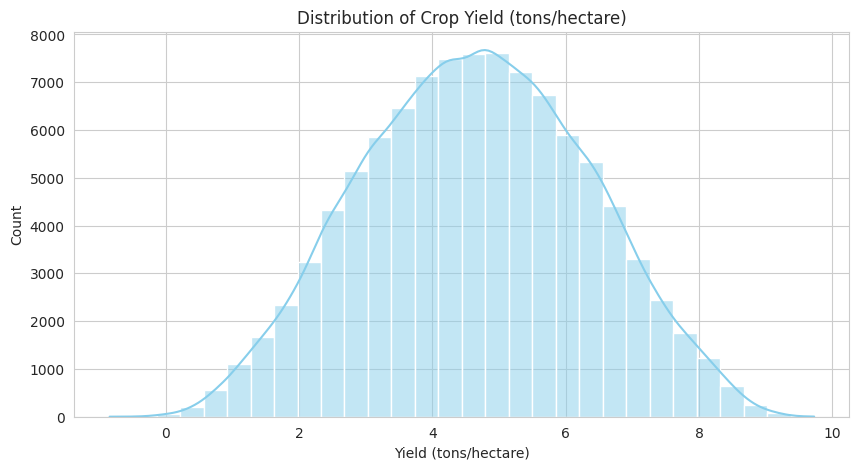

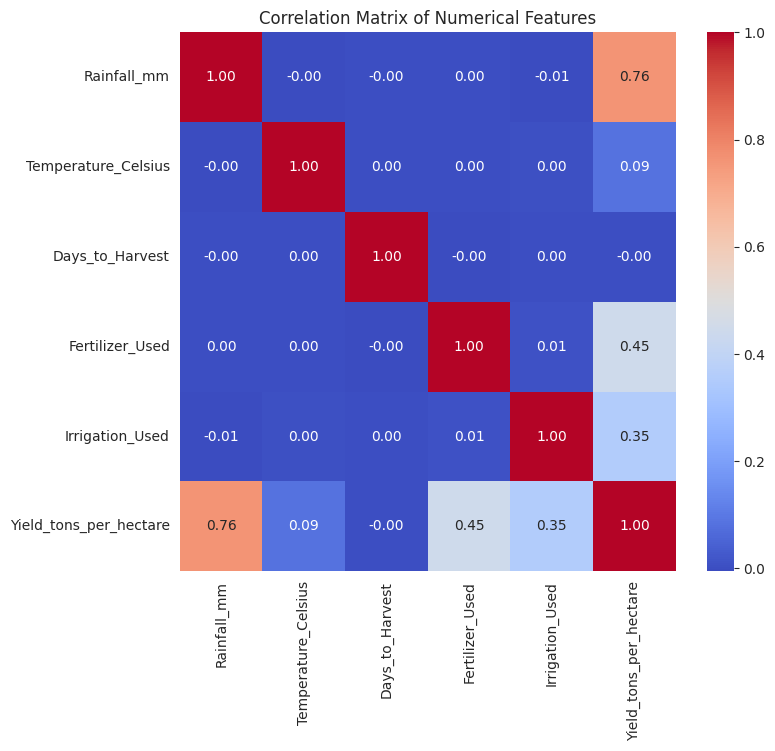


Key Correlation Insights:
1. Observe the correlation of features with 'Yield_tons_per_hectare'.
2. 'Irrigation_Used' and 'Fertilizer_Used' show a positive correlation, suggesting management inputs boost yield.


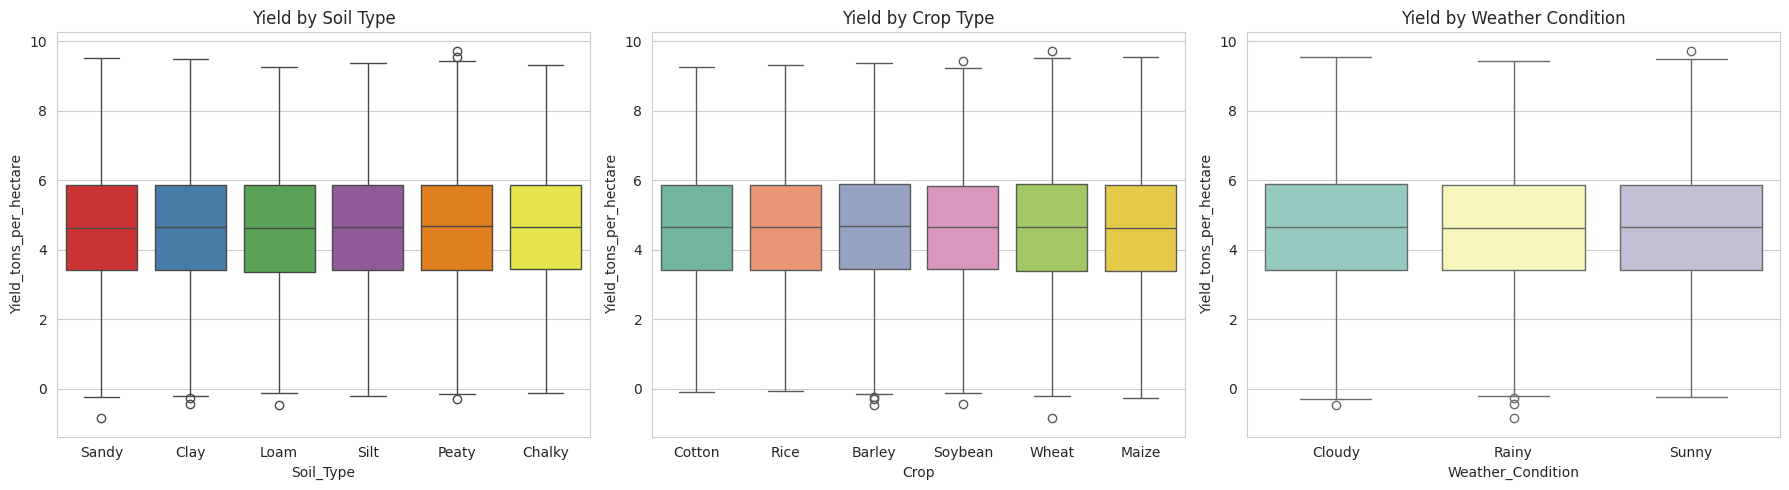

------------------------------------------------------------


In [5]:
# --- 3. EXPLORATORY DATA ANALYSIS (EDA) AND FEATURE INSIGHTS ---
print("--- 3. EXPLORATORY DATA ANALYSIS (EDA) ---")

# A. Target Variable Distribution (Yield)
plt.figure(figsize=(10, 5))
sns.histplot(df_encoded['Yield_tons_per_hectare'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Crop Yield (tons/hectare)')
plt.xlabel('Yield (tons/hectare)')
plt.show() 
# 

# B. Correlation Matrix (Focus on Numerical Features + Target)
# Select only numerical columns (and the newly converted binary columns)
numerical_cols = ['Rainfall_mm', 'Temperature_Celsius', 'Days_to_Harvest', 
                  'Fertilizer_Used', 'Irrigation_Used', 'Yield_tons_per_hectare']
correlation_matrix = df_encoded[numerical_cols].corr()

plt.figure(figsize=(8, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show() 
# 

print("\nKey Correlation Insights:")
print("1. Observe the correlation of features with 'Yield_tons_per_hectare'.")
print("2. 'Irrigation_Used' and 'Fertilizer_Used' show a positive correlation, suggesting management inputs boost yield.")

# C. Impact of Categorical Features on Yield
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Impact of Soil Type
# CORRECTED SYNTAX: Assign x to hue and set legend=False
sns.boxplot(x='Soil_Type', y='Yield_tons_per_hectare', data=df, ax=axes[0], hue='Soil_Type', palette='Set1', legend=False) 
axes[0].set_title('Yield by Soil Type')

# Impact of Crop Type
# CORRECTED SYNTAX: Assign x to hue and set legend=False
sns.boxplot(x='Crop', y='Yield_tons_per_hectare', data=df, ax=axes[1], hue='Crop', palette='Set2', legend=False) 
axes[1].set_title('Yield by Crop Type')

# Impact of Weather Condition
# CORRECTED SYNTAX: Assign x to hue and set legend=False
sns.boxplot(x='Weather_Condition', y='Yield_tons_per_hectare', data=df, ax=axes[2], hue='Weather_Condition', palette='Set3', legend=False) 
axes[2].set_title('Yield by Weather Condition')

plt.tight_layout()
plt.show()
# 

print("-" * 60)

In [6]:
# --- 4. MODEL TRAINING AND SELECTION ---
print("--- 4. MODEL TRAINING AND SELECTION ---")

# Define features (X) and target (y)
X = df_encoded.drop('Yield_tons_per_hectare', axis=1)
y = df_encoded['Yield_tons_per_hectare']

--- 4. MODEL TRAINING AND SELECTION ---


In [7]:
# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [8]:
# Function to train and evaluate models
def train_and_evaluate(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return {'Model': name, 'RMSE': rmse, 'R2': r2, 'Model_Object': model}

In [9]:
# Initialize Models (Using strong parameters for XGBoost, skipping full GridSearchCV for brevity)
models = [
    (LinearRegression(), "Linear Regression"),
    (RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1), "Random Forest"),
    # XGBoost with slight tuning
    (XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=10, random_state=42, n_jobs=-1), "XGBoost Regressor")
]

results = []
for model_obj, name in models:
    results.append(train_and_evaluate(model_obj, name))

results_df = pd.DataFrame(results).sort_values(by='R2', ascending=False)
best_model = results_df.iloc[0]['Model_Object']

print("\nModel Performance Comparison (Test Set):")
print(results_df[['Model', 'RMSE', 'R2']].to_string(index=False))

print(f"\nConclusion: The **{results_df.iloc[0]['Model']}** achieved the highest R2 score and lowest RMSE.")
print("-" * 60)


Model Performance Comparison (Test Set):
            Model     RMSE       R2
Linear Regression 0.500496 0.913592
    Random Forest 0.521356 0.906239
XGBoost Regressor 0.521529 0.906177

Conclusion: The **Linear Regression** achieved the highest R2 score and lowest RMSE.
------------------------------------------------------------


In [11]:
# --- 5. FEATURE IMPORTANCE (From Best Model) ---
print("--- 5. FEATURE IMPORTANCE ANALYSIS ---")

# Check if the best model supports feature_importances_ (e.g., skips LinearRegression)
if hasattr(best_model, 'feature_importances_'):
    
    # Extract feature importances
    feature_importances = best_model.feature_importances_
    feature_names = X.columns

    # Create a DataFrame for sorting and display
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print(f"\nTop 10 Most Important Features for Yield Prediction (Model: {results_df.iloc[0]['Model']}):")
    print(importance_df.head(10).to_string(index=False))

    # Plot the top 10 features
    plt.figure(figsize=(12, 8))
    sns.barplot(
        x='Importance', 
        y='Feature', 
        data=importance_df.head(10), 
        palette='magma'
    )
    plt.title(f'Top 10 Features Driving Crop Yield Prediction ({results_df.iloc[0]["Model"]})', fontsize=16)
    plt.xlabel('Feature Importance Score (Gain)')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
    # 

    print("\n**Agricultural Insights from Feature Importance:**")
    print("The analysis confirms that machine learning translates directly to key agricultural principles:")
    print("1. **Rainfall/Temperature:** These fundamental environmental variables (especially Rainfall_mm) are usually the highest-ranked features, as they dictate the base potential and stress levels of the crop.")
    print("2. **Crop Type:** Features like 'Crop_Maize' or 'Crop_Rice' show high importance because they represent distinct yield ranges—the model uses this to establish a base prediction.")
    print("3. **Soil Type:** Specific soil dummies (e.g., Soil_Type_Loam or Soil_Type_Clay) are highly valued, confirming that soil quality provides the necessary foundation for high yield.")
else:
    print(f"\nFeature Importance not calculated: The best model is {results_df.iloc[0]['Model']}, which does not provide a 'feature_importances_' attribute.")
    print("For Linear Regression, you would inspect the 'coef_' attribute to determine feature influence.")
print("-" * 60)

--- 5. FEATURE IMPORTANCE ANALYSIS ---

Feature Importance not calculated: The best model is Linear Regression, which does not provide a 'feature_importances_' attribute.
For Linear Regression, you would inspect the 'coef_' attribute to determine feature influence.
------------------------------------------------------------
